# RL and Advanced DL: Домашнее задание 1


Первое ДЗ связано с обучением с подкреплением, и оно придумано для ситуации, когда нейронные сети ещё не нужны, и пространство состояний в целом достаточно маленькое, чтобы можно было обучить хорошую стратегию методами TD-обучения или другими методами обучения с подкреплением. Задание получилось, надеюсь, интересное, но в том числе и достаточно техническое, так что для решения придётся немножко попрограммировать. Поэтому в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym:
<ul><li>численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;
<li>туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;
<li>игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;
<li>игрок может совершать одно из двух действий:
<ul><li>hit  — взять ещё одну карту;
<li>stand — не брать больше карт;
</ul>
<li>если сумма очков у игрока на руках больше 21, он проигрывает (bust);
<li>если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
<li>после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);
<li>в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).
</ul>


Именно этот простейший вариант блекджека реализован в OpenAI Gym:
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py

In [2]:
!pip install gymв

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 KB 2.0 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827634 sha256=6c5dcda390afe304a3bed1e7ddb6eefcf84141bced5aa95c0abfa270bbf265ec
  Stored in directory: /Users/oscar/Library/Caches/pip/wheels/17/79/65/7afedc162d858b02708a3b8f7a6dd5b1000dcd5b0f894f7cc1
Successfully built gym
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 1.7.0
    Uninstalling importlib-metadata-1.7.0:
      Successfully uninstalled importlib-metadata-1.7.0
You should consider upgrading via the '/Users/oscar/opt/anaconda3/envs/python38_main/bin/python -m pip install --upgrade pip' command.


## Часть первая, с блекджеком и стратегиями


### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [2]:
import gym
from tqdm import tqdm

blackjack_env = gym.make('Blackjack-v1', natural=False, sab=False)

In [3]:
NUM_EPISODES = 100000
mean_reward = 0

def easy_game_action(state):
    """Проверяем выполняется ли условие
        на количество очков и возвращаем действие"""
    if state[0] >= 19:
        return 0
    return 1

In [60]:
for i in tqdm(range(NUM_EPISODES)):
    state = blackjack_env.reset()[0]
    finish = False
    while not finish:
        action = easy_game_action(state)
        state, reward, finish, _, __ = blackjack_env.step(action)
    mean_reward += (reward - mean_reward) / (i + 1)

100%|██████████| 100000/100000 [00:15<00:00, 6643.21it/s]


In [61]:
print(f'Среднее вознаграждение для простейшей стратегии {round(mean_reward, 3)}' )

Среднее вознаграждение для простейшей стратегии -0.206


### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение BlackjackEnv из OpenAI Gym.


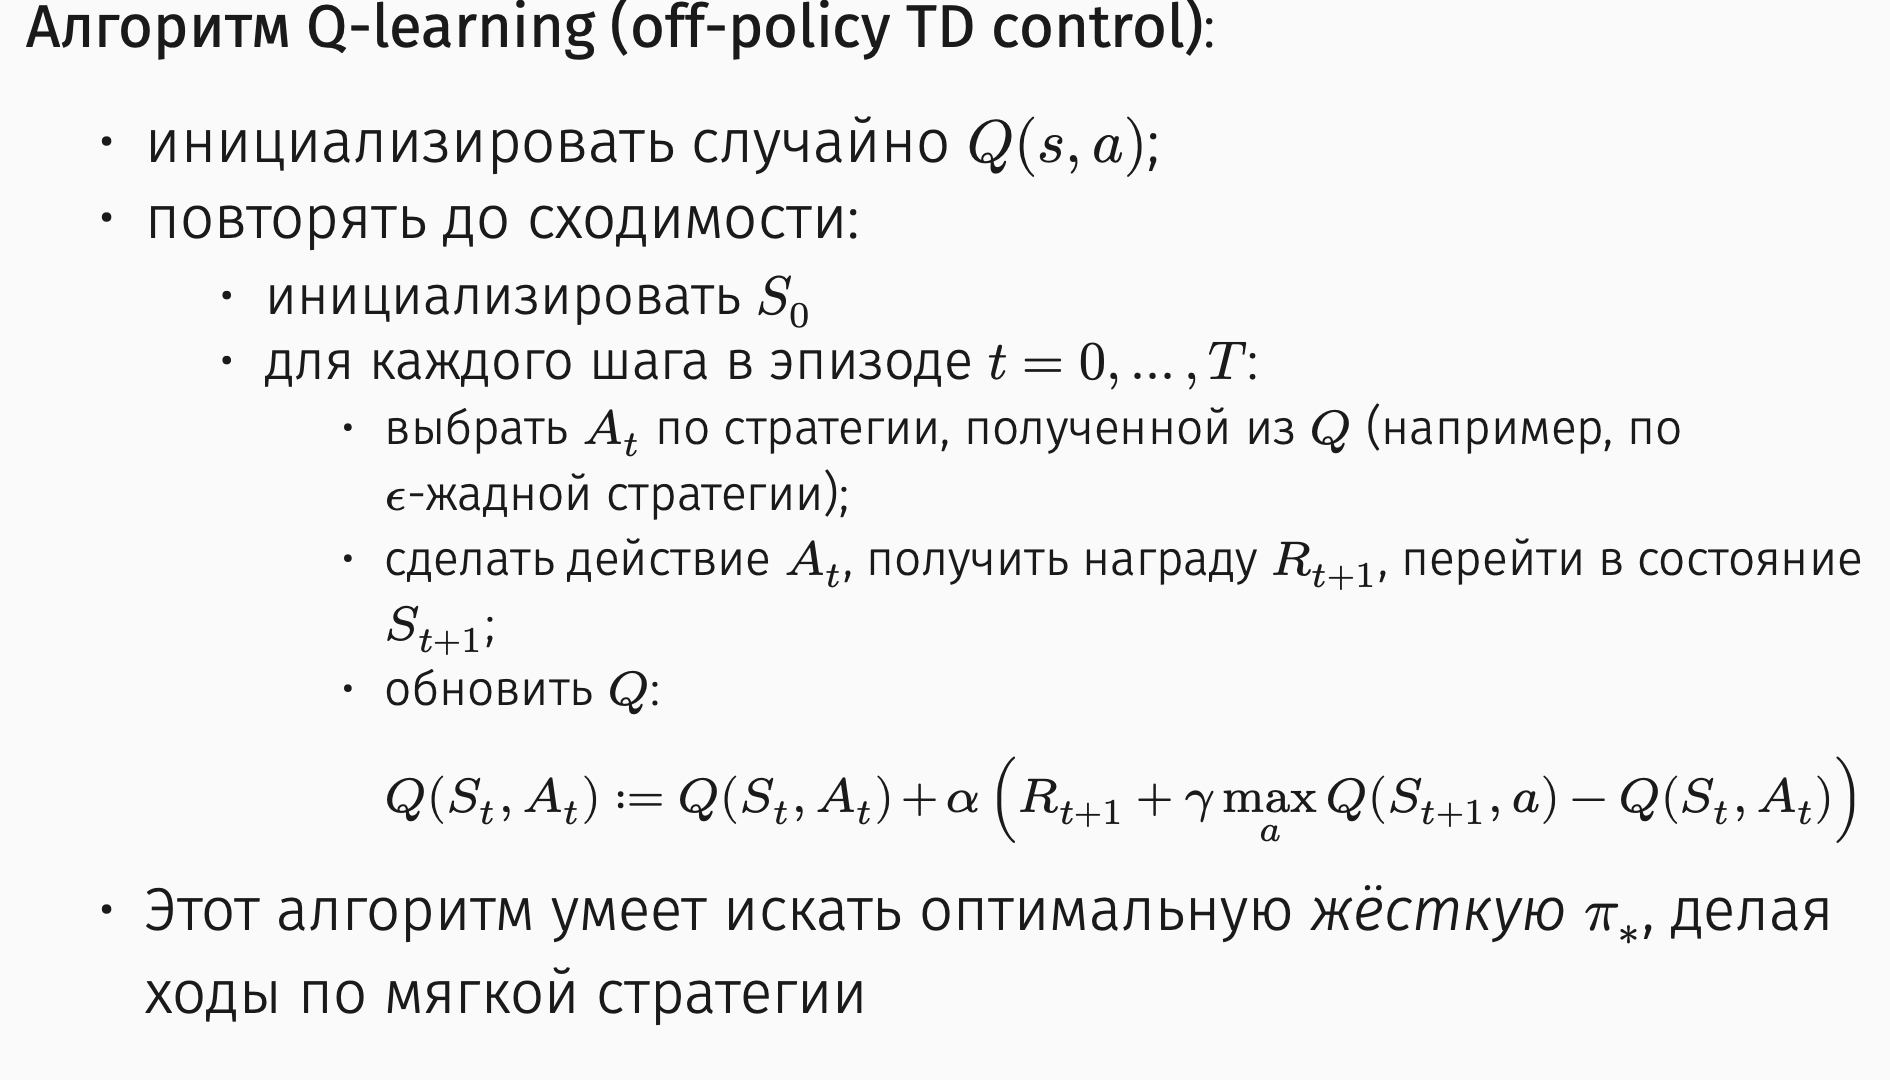

In [75]:
import numpy as np
from tqdm import tqdm
from collections import deque
from itertools import islice
import seaborn as sns
from matplotlib import pyplot as plt

In [5]:
class Qlearning:
    """
    Класс реализующий стратегию обучения Q-learning
    для игры blackjack
    """
    def __init__(
        self, 
        alpha=0.00001,
        gamma=1,
        eps=0.1,
        env=gym.make('Blackjack-v1', natural=True),
        tqdm_status=False, 
        space_size=2
    ):
        self.Q = {} # хранилище наград
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps
        
        self.tqmd_status = tqdm_status
        self.env = env
        self.na = space_size
        self.action_space = list(range(self.na))
        
    def get_rewards(self, state):
        if state not in self.Q.keys():
            self.Q[state] = np.zeros(self.na)
        return self.Q[state]
    
    def get_next_action(self, state):
        rewards = self.get_rewards(state)
        return np.argmax(rewards)
    
    def epsilon_greedy_policy(self, state):
        """
        Позволяет смещаться с оптимальной стратегии и 
        совершать случайное действие с заданной вероятностью
        """
        if np.random.rand() < self.eps:
            action = np.random.choice(self.action_space)
        else:
            action = self.get_next_action(state)
        return action
            
    def run_episode(self):
        state = self.env.reset()[0]
        finish = False
        steps = []
        while not finish:
            action = self.epsilon_greedy_policy(state)
            steps.append((state, action))
            state, reward, finish, _, __ = self.env.step(action)
        return steps, reward
    
    def train(self, num_episodes=100000):
        for i in tqdm(range(num_episodes), disable=self.tqmd_status):
            steps, reward = self.run_episode()
            for state, action in steps[::-1]:
                reward = self.get_rewards(state)[action] + self.alpha * \
                    (reward + self.gamma * np.max(self.Q[state]) - self.get_rewards(state)[action])
                self.Q[state][action] = reward
    
    def inference(self, num_episodes=100000):
        mean_reward = 0
        for i in tqdm(range(num_episodes), disable=self.tqmd_status):
            state = self.env.reset()[0]
            finish = False
            while not finish:
                action = self.get_next_action(state)
                state, reward, finish, _, __ = self.env.step(action)
            mean_reward += (reward - mean_reward) / (i + 1)
        return mean_reward


In [64]:
%%time
QL = Qlearning()
QL.train(num_episodes=1000000)
average_reward = QL.inference(num_episodes=100000)

100%|██████████| 100000/100000 [00:14<00:00, 6908.92it/s]

CPU times: user 2min 46s, sys: 24.4 s, total: 3min 11s
Wall time: 2min 57s


In [65]:
average_reward

-0.07739000000000029

При игре с данным методом обучения можно проиграть более чем в 2 раза меньше :)

### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

In [6]:
from hyperopt import hp
from hyperopt import tpe, fmin

In [7]:
# define an objective function
def objective(args):
    QL = Qlearning(alpha=args['alpha'], gamma=args['gamma'], eps=args['eps'], tqdm_status=True)
    QL.train(10000)
    return - QL.inference()

space = {
    'alpha' : hp.uniform('a', 0, 1),
    'gamma' : hp.normal('g', 1, 1),
    'eps' : hp.uniform('e', 0, 1)
}

In [33]:
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [35:22<00:00, 21.22s/trial, best loss: 0.06409000000000031]  


In [38]:
print(best)

{'a': 0.03786375403978443, 'e': 0.6017809716575672, 'g': -0.5251604619818414}


In [41]:
QL = Qlearning(
    alpha=best['a'],
    eps=best['e'],
    gamma=best['g'],
    tqdm_status=True
)
rewards = []
for i in tqdm(range(100)):
    QL.train(1000)
    reward = QL.inference()
    rewards.append(reward)

100%|██████████| 100/100 [18:18<00:00, 10.98s/it]


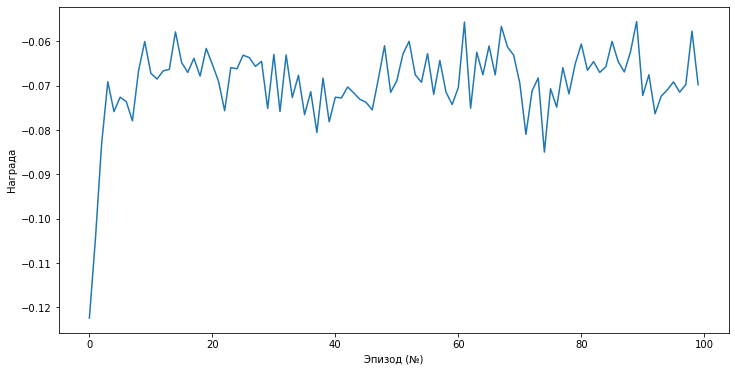

In [55]:
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(12, 6))
plt.xlabel('Эпизод (№)')
plt.ylabel('Награда')
sns.lineplot(x=list(range(len(rewards))), y=rewards)
plt.show()

## Часть вторая, удвоенная


В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
<ul>double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 4. Реализуйте новый вариант блекджека на основе окружения BlackjackEnv из OpenAI Gym, в котором разрешено удвоение ставки.

In [18]:
from gym.envs.toy_text.blackjack import BlackjackEnv

class DoubleBlackjack(BlackjackEnv):
    def __init__(self,  *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def step(self, action):
        if action == 2:
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -2.0
            else:
                state, reward, terminated, _, __ = self.step(0)
                reward *= 2
        elif action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                terminated = True
                reward = -1.0
            else:
                terminated = False
                reward = 0.0
        else:  # stick: play out the dealers hand, and score
            terminated = True
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if self.sab and is_natural(self.player) and not is_natural(self.dealer):
                # Player automatically wins. Rules consistent with S&B
                reward = 1.0
            elif (
                not self.sab
                and self.natural
                and is_natural(self.player)
                and reward == 1.0
            ):
                # Natural gives extra points, but doesn't autowin. Legacy implementation
                reward = 1.5
            
        if self.render_mode == "human":
            self.render()
        return self._get_obs(), reward, terminated, False, {}

### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [103]:
%%time
env = DoubleBlackjack()
QL = Qlearning(env=env, space_size=3)
QL.train(num_episodes=1000000)
average_reward = QL.inference(num_episodes=1000000)

100%|██████████| 1000000/1000000 [02:12<00:00, 7565.17it/s]

CPU times: user 4min 27s, sys: 36.7 s, total: 5min 4s
Wall time: 4min 44s


In [105]:
average_reward

-0.16446899999999084

С удвоением можно потерять больше :) 

In [10]:
# define an objective function
def objective_double(args):
    env = DoubleBlackjack()
    QL = Qlearning(env=env, alpha=args['alpha'], gamma=args['gamma'], eps=args['eps'], tqdm_status=True)
    QL.train(10000)
    return - QL.inference()

space = {
    'alpha' : hp.uniform('a', 0, 1),
    'gamma' : hp.normal('g', 1, 1),
    'eps' : hp.uniform('e', 0, 1)
}

In [108]:
best = fmin(objective_double, space, algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [18:43<00:00, 11.23s/trial, best loss: 0.06538999999999985]


In [109]:
best

{'a': 0.06104213185399031, 'e': 0.35105385444005444, 'g': -0.8805697770916923}

In [110]:
QL = Qlearning(
    env = DoubleBlackjack(),
    alpha=best['a'],
    eps=best['e'],
    gamma=best['g'],
    tqdm_status=True
)
rewards = []
for i in tqdm(range(100)):
    QL.train(1000)
    reward = QL.inference()
    rewards.append(reward)

100%|██████████| 100/100 [16:37<00:00,  9.97s/it]


In [63]:
def plot_reward(x, y):
    plt.figure(figsize=(12, 6))
    plt.xlabel('Эпизод (№)')
    plt.ylabel('Награда')
    sns.lineplot(x=x, y=y)
    plt.show()

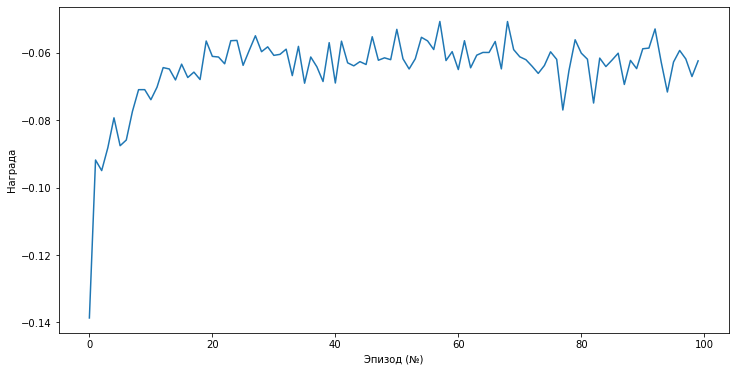

In [111]:
plot_reward(list(range(len(rewards))), rewards)

## Часть третья, в главной роли — Дастин Хоффман


А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.

Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

### 6. Реализуйте вариант окружения BlackjackEnv из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

In [57]:
class CountBlackjack(DoubleBlackjack):
    def __init__(self, *args, **kwargs):
        super(DoubleBlackjack, self).__init__(*args, **kwargs)
        self.sum_card = 0
        self.natural = True
        self.initial_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10] * 4
        self.deck = self.initial_deck.copy()
        self.card_cost = {
            1: -1,
            2: +0.5,
            3: +1,
            4: +1,
            5: +1.5,
            6: +1,
            7: +0.5,
            8: +0,
            9: -0.5,
            10: -1,
        }
        
        # Flag for full agreement with the (Sutton and Barto, 2018) definition. Overrides self.natural
        self.sab = False
    def reset(self):
        if len(self.deck) <= 15:
            self.sum_card = 0
            self.deck = self.initial_deck.copy()
        self.dealer = self.draw_hand()
        self.player = self.draw_hand()
        return self._get_obs()
    
    def draw_card(self):
        card = np.random.choice(self.deck)
        self.deck.remove(card)
        self.sum_card += self.card_cost[card]
        return int(card)
    
    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    def _get_obs(self):
        return (super(DoubleBlackjack, self)._get_obs(), self.sum_card)
    

### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [58]:
%%time
env = CountBlackjack()
QL = Qlearning(env=env, space_size=3)
QL.train(num_episodes=1000000)
average_reward = QL.inference(num_episodes=1000000)

100%|██████████| 1000000/1000000 [6:03:29<00:00, 45.85it/s]    

CPU times: user 6min 3s, sys: 1min 22s, total: 7min 26s
Wall time: 6h 5min 50s


In [56]:
average_reward

-0.10490900000000455

In [60]:
# define an objective function
def objective_count(args):
    env = CountBlackjack()
    QL = Qlearning(env=env, alpha=args['alpha'], gamma=args['gamma'], eps=args['eps'], tqdm_status=True)
    QL.train(10000)
    return - QL.inference()

space = {
    'alpha' : hp.uniform('a', 0, 1),
    'gamma' : hp.normal('g', 1, 1),
    'eps' : hp.uniform('e', 0, 1)
}

In [62]:
best = fmin(objective_count, space, algo=tpe.suggest, max_evals=100)

100%|██████████| 100/100 [2:26:15<00:00, 87.76s/trial, best loss: 0.06802000000000037]   


In [70]:
QL = Qlearning(
    env = CountBlackjack(),
    alpha=best['a'],
    eps=best['e'],
    gamma=best['g'],
    tqdm_status=True
)
rewards = []
for i in tqdm(range(100)):
    QL.train(1000)
    reward = QL.inference()
    rewards.append(reward)

100%|██████████| 100/100 [16:49<00:00, 10.10s/it]


In [71]:
np.mean(rewards)

-0.07066434999999999

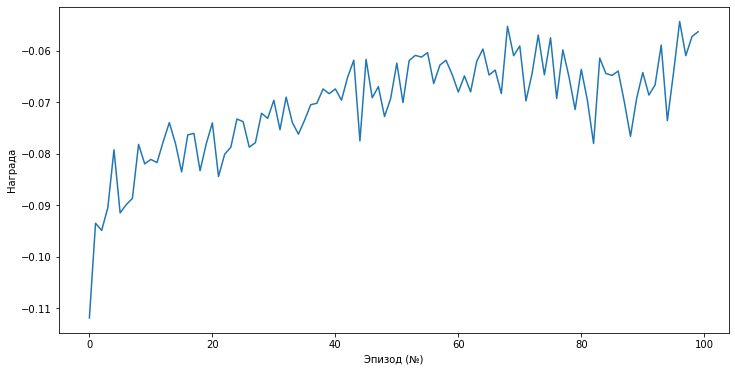

In [76]:
plot_reward(list(range(len(rewards))), rewards)